In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/Tomato",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
tomato_class_names = dataset.class_names

In [5]:
tomato_class_names, len(tomato_class_names)

(['Tomato_Bacterial_spot',
  'Tomato_Early_blight',
  'Tomato_Late_blight',
  'Tomato_Leaf_Mold',
  'Tomato_Septoria_leaf_spot',
  'Tomato_Spider_mites_Two_spotted_spider_mite',
  'Tomato__Target_Spot',
  'Tomato__Tomato_YellowLeaf__Curl_Virus',
  'Tomato__Tomato_mosaic_virus',
  'Tomato_healthy'],
 10)

In [6]:
len(dataset)

501

In [7]:
for img,label in dataset.take(1):
    print(img.shape)
    print(label.numpy())

(32, 256, 256, 3)
[5 6 6 5 7 7 9 0 9 9 7 7 9 4 9 7 4 6 0 0 6 5 2 9 2 5 9 0 3 7 6 0]


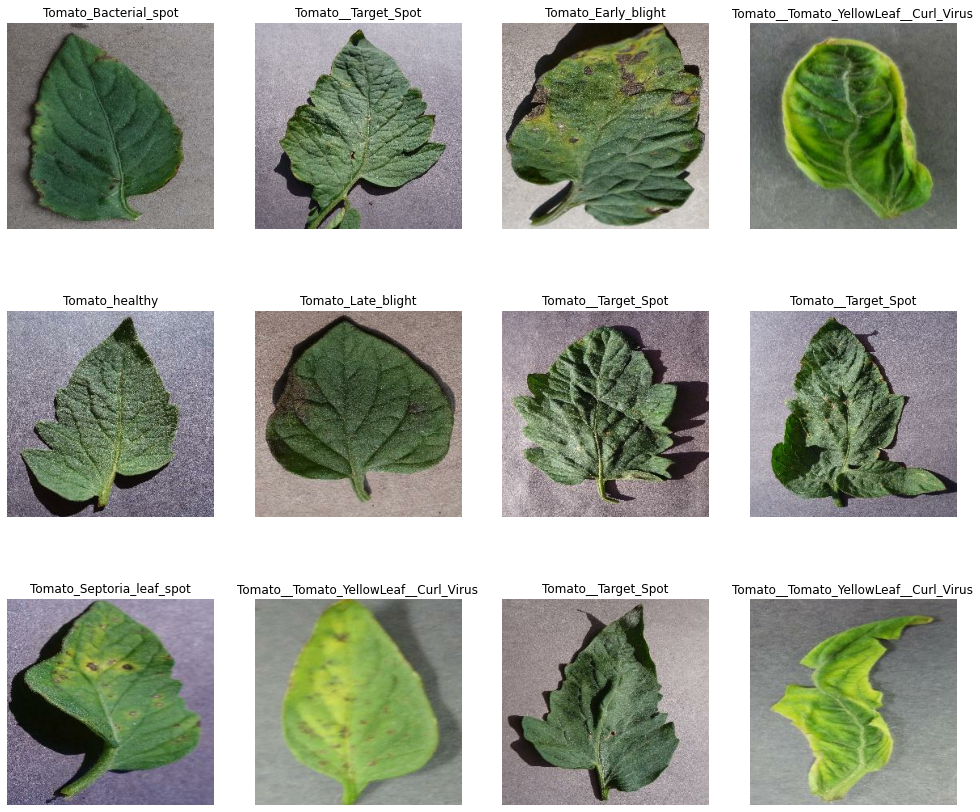

In [8]:
plt.figure(figsize=(17,15))
for img,label in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(tomato_class_names[label[i]])
        plt.axis("off")

In [9]:
# 80% --> training data
# 20% --> 10% validation, 10% test

In [10]:
train_size = 0.8
len(dataset)*train_size

400.8

In [11]:
train_ds = dataset.take(400)
len(train_ds)

400

In [12]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [13]:
val_sz = 0.1
len(dataset)*val_sz

50.1

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    ds_size = len(ds)
    
    train_size = int(ds_size * train_split)
    val_size   = int(ds_size * val_split) 
    
    train_ds   = dataset.take(train_size)
    test_ds    = dataset.skip(train_size)
    val_ds     = test_ds.take(val_size)
    test_ds    = test_ds.skip(val_size)
    
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(400, 50, 51)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(tomato_class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
400/400 [==============================] - 412s 1s/step - loss: 1.7396 - accuracy: 0.3745 - val_loss: 2.0241 - val_accuracy: 0.3663
Epoch 2/10
400/400 [==============================] - 396s 991ms/step - loss: 1.0337 - accuracy: 0.6315 - val_loss: 0.9820 - val_accuracy: 0.6756
Epoch 3/10
400/400 [==============================] - 418s 1s/step - loss: 0.7596 - accuracy: 0.7296 - val_loss: 0.8742 - val_accuracy: 0.6981
Epoch 4/10
400/400 [==============================] - 416s 1s/step - loss: 0.6256 - accuracy: 0.7727 - val_loss: 1.2561 - val_accuracy: 0.6175
Epoch 5/10
400/400 [==============================] - 408s 1s/step - loss: 0.5311 - accuracy: 0.8137 - val_loss: 0.7568 - val_accuracy: 0.7600
Epoch 6/10
400/400 [==============================] - 416s 1s/step - loss: 0.4351 - accuracy: 0.8480 - val_loss: 0.4725 - val_accuracy: 0.8413
Epoch 7/10
400/400 [==============================] - 414s 1s/step - loss: 0.3851 - accuracy: 0.8647 - val_loss: 0.5880 - val_accuracy: 0.8

In [24]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 42s 458ms/step - loss: 0.3879 - accuracy: 0.8579


In [25]:
scores

[0.3879203200340271, 0.8578522801399231]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 400}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
len(history.history['accuracy'])

10

In [30]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

Text(0.5, 1.0, 'Loss over each epochs')

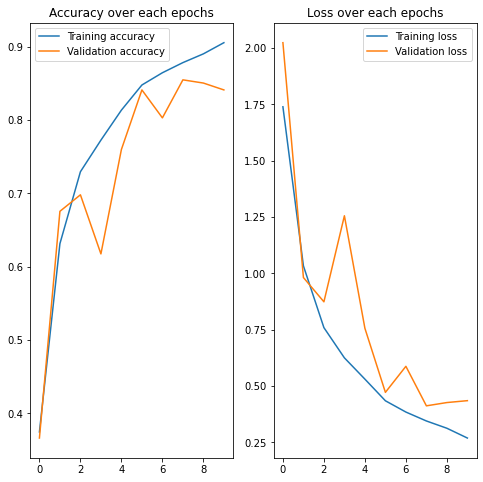

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation accuracy')
plt.legend()
plt.title('Accuracy over each epochs')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Loss over each epochs')

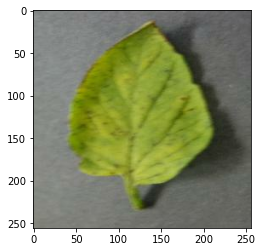

In [32]:
for img,label in test_ds.take(1):
    
    plt.imshow(img[0].numpy().astype('uint8'))

first image to predict
actual label:  Tomato_Late_blight
Predicted label:  Tomato_Late_blight


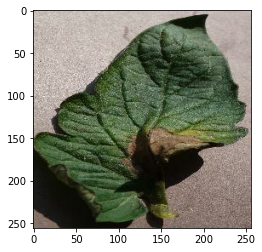

In [34]:
import numpy as np
for img,label in test_ds.take(1):
    
    first_img = img[0].numpy().astype('uint8')
    first_label = label[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_img)
    print('actual label: ', tomato_class_names[first_label])
    
    batch_prediction = model.predict(img)
    print('Predicted label: ', tomato_class_names[np.argmax(batch_prediction[0])])

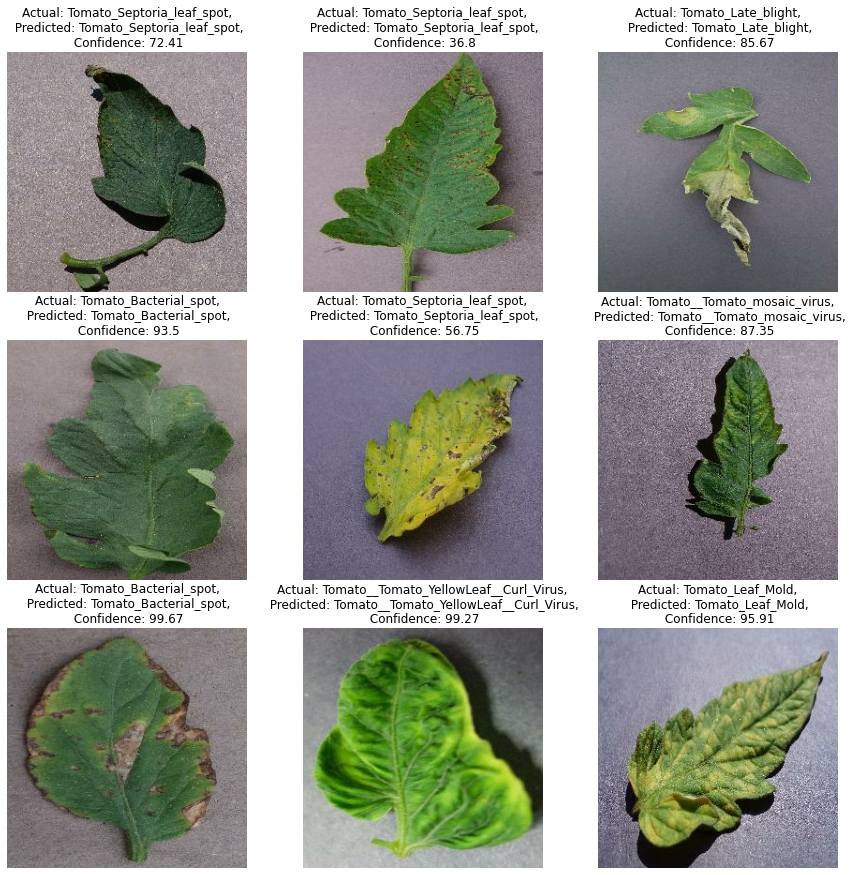

In [35]:
plt.figure(figsize=(15,15))
for img,label in test_ds.take(1):
    
    batch_prediction = model.predict(img)
    
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.axis('off')
        
        confidence = round(100*np.max(batch_prediction[i]), 2)
        predicted_class = tomato_class_names[np.argmax(batch_prediction[i])]
        
        plt.title(f'''Actual: {tomato_class_names[label[i]]},\n Predicted: {predicted_class},\n Confidence: {confidence}''')

In [36]:
model_version = 1
model.save(f"Models/Tomato/{model_version}")

INFO:tensorflow:Assets written to: Models/Tomato/1\assets


In [37]:
import os
model_version = max([int(i) for i in os.listdir('Models/Tomato/')])+1
model_version

2

In [38]:
model.save(f"Models/Tomato/{model_version}")

INFO:tensorflow:Assets written to: Models/Tomato/2\assets
